In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from sklearn.base import BaseEstimator, TransformerMixin

class TimestampCleaner(BaseEstimator, TransformerMixin):
    def __init__(self, drop_na=True, strip_timezone=False, store_as_utc=False):
        self.drop_na = drop_na
        self.strip_timezone = strip_timezone
        self.store_as_utc = store_as_utc
        
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        for column in X.columns:
            if 'date' in column:
                if self.strip_timezone:
                    print(f'Stripping incorrect timezone adjustments in column "{column}"')
                    X[column] = X[column].str[:-6]
                print(f'Transforming column "{column}" from {X[column].dtype} to datetime')
                X[column] = pd.to_datetime(X[column]).dt.tz_localize('Europe/Tallinn', nonexistent='NaT', ambiguous='NaT')
                if self.store_as_utc:
                    print(f'Converting column "{column}" to UTC')
                    X[column] = X[column].dt.tz_convert('UTC')
        if self.drop_na and X.isna().sum().sum() > 0:
            print(f'Dropping {X.isna().sum().sum()} NaN values')
            X = X.dropna()
        return X


class DatetimeFeaturesAppender(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        for column in X.columns:
            if 'date' in column:
                X[f'{column}_year'] = X[column].dt.year
                X[f'{column}_month'] = X[column].dt.month
                X[f'{column}_day'] = X[column].dt.day
                X[f'{column}_hour'] = X[column].dt.hour
                X[f'{column}_dayofweek'] = X[column].dt.dayofweek
                X[f'{column}_dayofyear'] = X[column].dt.dayofyear
        return X

In [3]:
from sklearn.pipeline import Pipeline

timestamp_cleaner = TimestampCleaner()

train_csv_pipeline = Pipeline([
    ('timestamp_cleaner', timestamp_cleaner),
    ('datetime_features_appender', DatetimeFeaturesAppender())
])

train_df = pd.read_csv('downloads/train.csv')
train_df = train_csv_pipeline.transform(train_df)

Transforming column "datetime" from object to datetime
Dropping 1056 NaN values


In [4]:
def plot_df(df, plot_year, plot_month, plot_day, plot_unit_id=20, is_consumption=1):
    df = df[(df.prediction_unit_id == plot_unit_id) &
            (df.datetime.dt.year == plot_year) &
            (df.datetime.dt.month == plot_month) &
            (df.datetime.dt.day == plot_day) &
            (df.is_consumption == is_consumption)]
    plt.plot(df.datetime.dt.hour, df.target, label=f'{plot_year}-{plot_month}-{plot_day}')

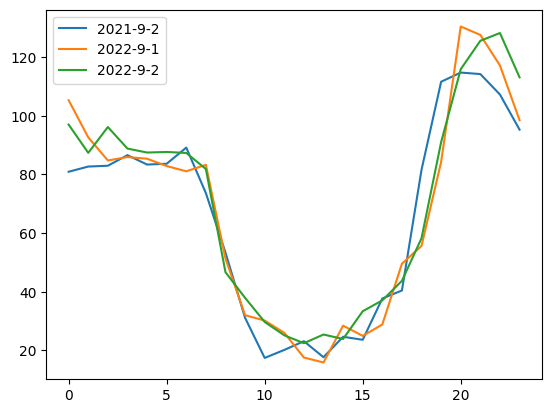

In [5]:
plot_df(train_df, 2021, 9, 2)
plot_df(train_df, 2022, 9, 1)
plot_df(train_df, 2022, 9, 2)
plt.legend(loc='best')

In [6]:
train_df.head()

,county,is_business,product_type,target,is_consumption,datetime,data_block_id,row_id,prediction_unit_id,datetime_year,datetime_month,datetime_day,datetime_hour,datetime_dayofweek,datetime_dayofyear
0,0,0,1,0.713,0,2021-09-01 00:00:00+03:00,0,0,0,2021,9,1,0,2,244
1,0,0,1,96.590,1,2021-09-01 00:00:00+03:00,0,1,0,2021,9,1,0,2,244
2,0,0,2,0.000,0,2021-09-01 00:00:00+03:00,0,2,1,2021,9,1,0,2,244
3,0,0,2,17.314,1,2021-09-01 00:00:00+03:00,0,3,1,2021,9,1,0,2,244
4,0,0,3,2.904,0,2021-09-01 00:00:00+03:00,0,4,2,2021,9,1,0,2,244


In [7]:
gas_prices_df = pd.read_csv('downloads/gas_prices.csv')
gas_prices_df = timestamp_cleaner.transform(gas_prices_df)
gas_prices_df.head()

Transforming column "forecast_date" from object to datetime
Transforming column "origin_date" from object to datetime


,forecast_date,lowest_price_per_mwh,highest_price_per_mwh,origin_date,data_block_id
0,2021-09-01 00:00:00+03:00,45.23,46.32,2021-08-31 00:00:00+03:00,1
1,2021-09-02 00:00:00+03:00,45.62,46.29,2021-09-01 00:00:00+03:00,2
2,2021-09-03 00:00:00+03:00,45.85,46.40,2021-09-02 00:00:00+03:00,3
3,2021-09-04 00:00:00+03:00,46.30,46.80,2021-09-03 00:00:00+03:00,4
4,2021-09-05 00:00:00+03:00,46.30,46.58,2021-09-04 00:00:00+03:00,5


In [8]:
train_df = pd.merge(train_df, gas_prices_df, how='left', on=['data_block_id'])

In [12]:
electricity_prices_df = pd.read_csv('downloads/electricity_prices.csv')
electricity_prices_df = timestamp_cleaner.transform(electricity_prices_df)
electricity_prices_df.head()

Transforming column "forecast_date" from object to datetime
Transforming column "origin_date" from object to datetime
Dropping 8 NaN values


,forecast_date,euros_per_mwh,origin_date,data_block_id
0,2021-09-01 00:00:00+03:00,92.51,2021-08-31 00:00:00+03:00,1
1,2021-09-01 01:00:00+03:00,88.90,2021-08-31 01:00:00+03:00,1
2,2021-09-01 02:00:00+03:00,87.35,2021-08-31 02:00:00+03:00,1
3,2021-09-01 03:00:00+03:00,86.88,2021-08-31 03:00:00+03:00,1
4,2021-09-01 04:00:00+03:00,88.43,2021-08-31 04:00:00+03:00,1


In [13]:
train_df[train_df.data_block_id==1]

,county,is_business,product_type,target,is_consumption,datetime,data_block_id,row_id,prediction_unit_id,datetime_year,datetime_month,datetime_day,datetime_hour,datetime_dayofweek,datetime_dayofyear,forecast_date,lowest_price_per_mwh,highest_price_per_mwh,origin_date
2928,0,0,1,1.687,0,2021-09-02 00:00:00+03:00,1,2928,0,2021,9,2,0,3,245,2021-09-01 00:00:00+03:00,45.23,46.32,2021-08-31 00:00:00+03:00
2929,0,0,1,109.366,1,2021-09-02 00:00:00+03:00,1,2929,0,2021,9,2,0,3,245,2021-09-01 00:00:00+03:00,45.23,46.32,2021-08-31 00:00:00+03:00
2930,0,0,2,0.000,0,2021-09-02 00:00:00+03:00,1,2930,1,2021,9,2,0,3,245,2021-09-01 00:00:00+03:00,45.23,46.32,2021-08-31 00:00:00+03:00
2931,0,0,2,21.008,1,2021-09-02 00:00:00+03:00,1,2931,1,2021,9,2,0,3,245,2021-09-01 00:00:00+03:00,45.23,46.32,2021-08-31 00:00:00+03:00
2932,0,0,3,1.003,0,2021-09-02 00:00:00+03:00,1,2932,2,2021,9,2,0,3,245,2021-09-01 00:00:00+03:00,45.23,46.32,2021-08-31 00:00:00+03:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5851,15,0,3,59.302,1,2021-09-02 23:00:00+03:00,1,5851,58,2021,9,2,23,3,245,2021-09-01 00:00:00+03:00,45.23,46.32,2021-08-31 00:00:00+03:00
5852,15,1,1,0.000,0,2021-09-02 23:00:00+03:00,1,5852,59,2021,9,2,23,3,245,2021-09-01 00:00:00+03:00,45.23,46.32,2021-08-31 00:00:00+03:00
5853,15,1,1,21.756,1,2021-09-02 23:00:00+03:00,1,5853,59,2021,9,2,23,3,245,2021-09-01 00:00:00+03:00,45.23,46.32,2021-08-31 00:00:00+03:00
5854,15,1,3,0.000,0,2021-09-02 23:00:00+03:00,1,5854,60,2021,9,2,23,3,245,2021-09-01 00:00:00+03:00,45.23,46.32,2021-08-31 00:00:00+03:00
